In [1]:
import pandas as pd
import csv
import numpy as np
import scipy
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import random



from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.model_selection import GridSearchCV
from sklearn import datasets
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import requests
import itertools
import networkx as nx
import datetime
import io
import random
import warnings
import json
import requests
import time
import csv
import re
sns.set_palette("husl")


In [2]:
gene_loov_df = pd.read_csv('./data_generated/gene_loov_prob.csv')
gene_loov_df = gene_loov_df.sort_values('Probability',ascending = False)
gene_loov_df['pct_rank'] = gene_loov_df.groupby('Tissue')['Probability'].rank(pct=True)
gene_loov_df[gene_loov_df['Tissue'] == 'Brain'].head()

,Gene,Tissue,Label,Probability,Description,pct_rank
109450,ENSG00000154277,Brain,P,0.988585,UCHL1,1.000000
280323,ENSG00000127720,Brain,U,0.988544,METTL25,0.999935
443438,ENSG00000147140,Brain,U,0.987343,NONO,0.999871
219049,ENSG00000181090,Brain,P,0.987120,EHMT1,0.999806
440922,ENSG00000102003,Brain,P,0.986731,SYP,0.999742


In [3]:
gwas = pd.read_csv('./data/GWAS', sep = '\t')
gwas = gwas.drop(columns = ['DATE ADDED TO CATALOG', 'PUBMEDID', 'FIRST AUTHOR', 'DATE', 'JOURNAL',
                         'INITIAL SAMPLE SIZE', 'STUDY',
       'REPLICATION SAMPLE SIZE','INTERGENIC',
       'RISK ALLELE FREQUENCY', 'P-VALUE', 'P-VALUE (TEXT)',
       'OR or BETA', '95% CI (TEXT)', 'PLATFORM [SNPS PASSING QC]'])
print(gwas.shape)


(157336, 19)


/nfshomes/gowthami/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (23,27,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
gwas.head()

,LINK,DISEASE/TRAIT,REGION,CHR_ID,CHR_POS,REPORTED GENE(S),MAPPED_GENE,UPSTREAM_GENE_ID,DOWNSTREAM_GENE_ID,SNP_GENE_IDS,UPSTREAM_GENE_DISTANCE,DOWNSTREAM_GENE_DISTANCE,STRONGEST SNP-RISK ALLELE,SNPS,MERGED,SNP_ID_CURRENT,CONTEXT,PVALUE_MLOG,CNV
0,www.ncbi.nlm.nih.gov/pubmed/21801394,Drug-induced Stevens-Johnson syndrome or toxic...,6p21.33,6,31440051,HCP5,"HCP5, HCP5, HCP5",NaN,NaN,"ENSG00000237105, ENSG00000206337, ENSG00000230389",NaN,NaN,rs9469003-C,rs9469003,0,9.469e+06,intron_variant,8.698970,N
1,www.ncbi.nlm.nih.gov/pubmed/21743467,Prostate cancer,2p11.2,2,85567174,"GGCX, VAMP8, VAMP5, RNF181",VAMP8,NaN,NaN,ENSG00000118640,NaN,NaN,rs10187424-A,rs10187424,0,1.01874e+07,intron_variant,14.522879,N
2,www.ncbi.nlm.nih.gov/pubmed/21743467,Prostate cancer,2q37.3,2,237478585,intergenic,AC112721.2 - MLPH,ENSG00000222032,ENSG00000115648,NaN,43763.0,6843.0,rs7584330-C,rs7584330,0,7.58433e+06,intergenic_variant,8.522879,N
3,www.ncbi.nlm.nih.gov/pubmed/21743467,Prostate cancer,3q23,3,141383991,ZBTB38,ZBTB38,NaN,NaN,ENSG00000177311,NaN,NaN,rs6763931-T,rs6763931,0,6.76393e+06,intron_variant,7.698970,N
4,www.ncbi.nlm.nih.gov/pubmed/21743467,Prostate cancer,3q26.2,3,170412314,"CLDN11, SKIL",AC073288.2,NaN,NaN,ENSG00000242578,NaN,NaN,rs10936632-A,rs10936632,0,1.09366e+07,intron_variant,21.154902,N


In [5]:
disease = 'Liver enzyme levels (gamma-glutamyl transferase)'
tissue = 'Liver'

In [6]:
prob_df = gene_loov_df[['Tissue','Description','Probability']]

rel_genes = gwas[gwas['DISEASE/TRAIT']==disease]['MAPPED_GENE'].tolist()
rel_genes = [x for x in rel_genes if str(x) != 'nan']
rel_genes = [s.split('-') or s.split(',') for s in rel_genes]
rel_genes = list(itertools.chain.from_iterable(rel_genes))
rel_genes = [x.strip(' ') for x in rel_genes]
gtex_genes = set(prob_df['Description'].tolist())
gwas_genes = list(set(rel_genes) & gtex_genes)
len(gwas_genes)

21

In [9]:

gt_param_df = pd.read_csv('./data_generated/gt_param_df_wlabel.csv')
gt_param_df = gt_param_df[['Tissue','Description','ZScore','MeanExp','Breadth','CV','NeighborMeanBreadth','NeighborMeanZscore','Label']]
# gt_param_df = gt_param_df[gt_param_df['Description'].isin(gwas_genes)]
# gt_param_df = gt_param_df[gt_param_df['Tissue']==tissue]
# gt_param_df = pd.merge(gt_param_df, prob_df,  how='inner', 
#                        left_on=['Description','Tissue'], right_on = ['Description','Tissue'])
# print(gt_param_df.shape)
# gt_param_df.to_csv('./data_generated/gwas_'+ disease +'.csv',index = False)

gt_param_df.head()

,Tissue,Description,ZScore,MeanExp,Breadth,CV,NeighborMeanBreadth,NeighborMeanZscore,Label
0,Stomach,SAMD11,-0.036851,4.720096,0.763231,0.904074,0.296060,-0.366241,U
1,Stomach,NOC2L,-0.412520,44.847466,0.220056,0.353527,0.349456,-0.245143,N
2,Stomach,KLHL17,-0.145059,11.037735,0.445682,0.398152,0.300836,-0.350367,U
3,Stomach,PLEKHN1,-0.314139,1.643722,0.682451,1.065057,0.470752,0.818392,U
4,Stomach,PERM1,-0.298348,0.612194,0.454039,0.705991,0.311978,-0.253442,N


In [13]:
pos_df = gt_param_df[gt_param_df['Label']=='P']
pos_df.head()

,Tissue,Description,ZScore,MeanExp,Breadth,CV,NeighborMeanBreadth,NeighborMeanZscore,Label
44,Stomach,SKI,-0.501055,35.633789,0.239554,0.670279,0.338603,-0.270250,P
305,Testis,DVL1,1.733058,139.861359,0.994460,0.214364,0.508105,0.123451,P
328,Testis,SKI,-0.529421,34.230247,0.049861,0.262963,0.396814,-0.176371,P
384,Brain,AGRN,-0.277814,20.184099,0.356927,0.706896,0.351060,-0.091994,P
390,Brain,B3GALT6,-0.132929,12.762970,0.469341,0.462932,0.371991,-0.124069,P


In [16]:
tissue_keywords = ['Lung','Cardio','Heart','Epilepsy','Alz','Brain','Breast','Liver',
                   'Pancre','Uterin','Gastric','Ovar','Prost','Colon']
gtex_tissues = ['Lung','Heart','Heart','Brain','Brain','Brain','Breast','Liver',
                'Pancreas','Uterus','Stomach','Ovary','Prostate','Colon']

cancerwords = ['noma', 'cancer','Cancer']

# tissue_keywords = ['Lung']
# gtex_tissues = ['Lung']
table_tissue = []
table_disease = []
table_gg_count = []
table_pval = []
gwas_rank_list = []
rand_rank_list = []

for tissue_keyword, gtex_tissue in zip(tissue_keywords,gtex_tissues):
    print(tissue_keyword, gtex_tissue)
    diseases = gwas[gwas['DISEASE/TRAIT'].str.contains(tissue_keyword,
                                                       case=False)]['DISEASE/TRAIT'].drop_duplicates().tolist()
    diseases = [el for el in diseases if not any(ignore in el for ignore in cancerwords)]
    prob_df = gene_loov_df[gene_loov_df['Tissue'] == gtex_tissue]
    prob_df['pct_rank'] = prob_df['Probability'].rank(pct=True)
    pos_genes = pos_df[pos_df['Tissue']==gtex_tissue]['Description'].tolist()
    
    for disease in diseases:
        rel_genes = gwas[gwas['DISEASE/TRAIT']==disease]['MAPPED_GENE'].tolist()
        rel_genes = [x for x in rel_genes if str(x) != 'nan']
        rel_genes = [s.split('-') or s.split(',') for s in rel_genes]
        rel_genes = list(itertools.chain.from_iterable(rel_genes))
        rel_genes = [x.strip(' ') for x in rel_genes]
        gtex_genes = set(prob_df['Description'].tolist())
        gwas_genes = list((set(rel_genes) & gtex_genes)-set(pos_genes))
        if len(gwas_genes)>=20:
            print('The count of Pos genes',len(list(set(rel_genes) & set(pos_genes))))
#             print(gwas_genes)
            random_count = int(len(gwas_genes)*0.9)
            gwas_ranks = []
            rand_ranks = []
            for i in range(30):
                gwas_list = random.sample(gwas_genes,random_count)
                rand_list = random.sample(gtex_genes,random_count)
                gwas_rank = np.mean(prob_df[prob_df['Description'].isin(gwas_list)]['pct_rank'].tolist())
                rand_rank = np.mean(prob_df[prob_df['Description'].isin(rand_list)]['pct_rank'].tolist())
                gwas_ranks.append(gwas_rank)
                rand_ranks.append(rand_rank)
            
            pval =scipy.stats.mannwhitneyu(gwas_ranks, rand_ranks, alternative='greater')[1]
            table_tissue.append(gtex_tissue)
            table_disease.append(disease)
            table_gg_count.append(len(gwas_genes))
            table_pval.append(pval)
            gwas_rank_list.append(gwas_ranks)
            rand_rank_list.append(rand_ranks)
            print(str(disease)+' : '+str(len(gwas_genes)) + ' - Pval: ' + str(pval))
#             print(gwas_ranks)
#             _=sns.kdeplot(gwas_ranks, shade=True, color = 'darkgoldenrod')
#             _=sns.kdeplot(rand_ranks, shade=True, color = 'pink')

#     print('-----')

Lung Lung
The count of Pos genes 3


/cmlscratch/gowthami/Anaconda3/envs/torch_projects/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Lung function (FEV1) : 48 - Pval: 0.9954656195033632
The count of Pos genes 29
Lung function (FEV1/FVC) : 465 - Pval: 8.489763008551159e-09
The count of Pos genes 19
Lung function (FVC) : 399 - Pval: 5.511699730548812e-09
Cardio Heart
The count of Pos genes 12
Cardiovascular disease : 212 - Pval: 0.7898068351960934
Heart Heart
The count of Pos genes 2
Coronary heart disease : 45 - Pval: 0.0066359023699551455
The count of Pos genes 8
Resting heart rate : 68 - Pval: 1.6691944102144e-11
The count of Pos genes 5
Coronary artery disease (myocardial infarction, percutaneous transluminal coronary angioplasty, coronary artery bypass grafting, angina or chromic ischemic heart disease) : 51 - Pval: 0.7678635446891924
The count of Pos genes 1
Heart rate in heart failure with reduced ejection fraction : 45 - Pval: 0.37529361576115317
Epilepsy Brain
Alz Brain
The count of Pos genes 10
Alzheimer's disease : 43 - Pval: 0.9999998902057233
The count of Pos genes 9
Alzheimer's disease (late onset) : 55 

In [17]:
gwas_val_df = pd.DataFrame({'Tissue': table_tissue,
                           'Disease': table_disease,
                           '#ofgenes': table_gg_count,
                           'pval': table_pval,
                           'GWAS_ranks':gwas_rank_list,
                           'Rand_Ranks':rand_rank_list})

gwas_val_df = gwas_val_df.sort_values(by=['#ofgenes'], ascending=False)
mean_ranks = []
for _, row in gwas_val_df.iterrows():
    mean_ranks.append(np.mean(row['GWAS_ranks']))
    
gwas_val_df['Mean_Gwas_rank'] = mean_ranks

gwas_val_df['disease_numb'] = gwas_val_df['Mean_Gwas_rank'].rank(ascending = False)

gwas_val_df = gwas_val_df.sort_values(by=['Mean_Gwas_rank'], ascending=True)

gwas_val_df.to_csv('./data_generated/GWAS_pval_intersecting_genes.csv',index = False)
gwas_val_df.head()

,Tissue,Disease,#ofgenes,pval,GWAS_ranks,Rand_Ranks,Mean_Gwas_rank,disease_numb
21,Colon,Colonoscopy-negative controls vs population co...,62,1.000000,"[0.39466518611500023, 0.37326799594457594, 0.3...","[0.4979831506783181, 0.5098307826002992, 0.548...",0.382192,22.0
14,Brain,Alzheimer's disease or family history of Alzhe...,46,1.000000,"[0.42305717516686986, 0.43615476449224, 0.4454...","[0.5833561706403582, 0.49378510251588376, 0.51...",0.435513,21.0
15,Breast,Breast size,30,0.999996,"[0.42726206454577337, 0.4218425412026456, 0.43...","[0.3680777741502521, 0.4486257723606728, 0.486...",0.441333,20.0
8,Brain,Alzheimer's disease,43,1.000000,"[0.4186973633230694, 0.44130691898285024, 0.44...","[0.6072275807690478, 0.512823127170891, 0.4959...",0.454462,19.0
11,Brain,Alzheimer disease and age of onset,81,0.999962,"[0.44764087993456453, 0.4732294043365333, 0.46...","[0.49587082239155084, 0.5894688033636116, 0.45...",0.459892,18.0


In [18]:
# gwas_val_df = gwas_val_df.sort_values(by=['Mean_Gwas_rank'], ascending=False)
gwas_val_df = gwas_val_df[['disease_numb','GWAS_ranks']]
import itertools
from itertools import chain


diseases = gwas_val_df['disease_numb'].tolist()
diseases_rep = list(itertools.chain.from_iterable(itertools.repeat(x, 30) for x in diseases))

gwas_ranks = list(chain.from_iterable(gwas_val_df['GWAS_ranks'].tolist()))

gwas_val_df_t = pd.DataFrame({'Disease':diseases_rep,'GWAS_ranks':gwas_ranks})
# gwas_val_df = pd.melt(gwas_val_df, id_vars=['Tissue','Disease'], value_vars=['GWAS_ranks','Rand_Ranks'])
gwas_val_df_t.head()

,Disease,GWAS_ranks
0,22.0,0.394665
1,22.0,0.373268
2,22.0,0.378662
3,22.0,0.385343
4,22.0,0.366001


No handles with labels found to put in legend.


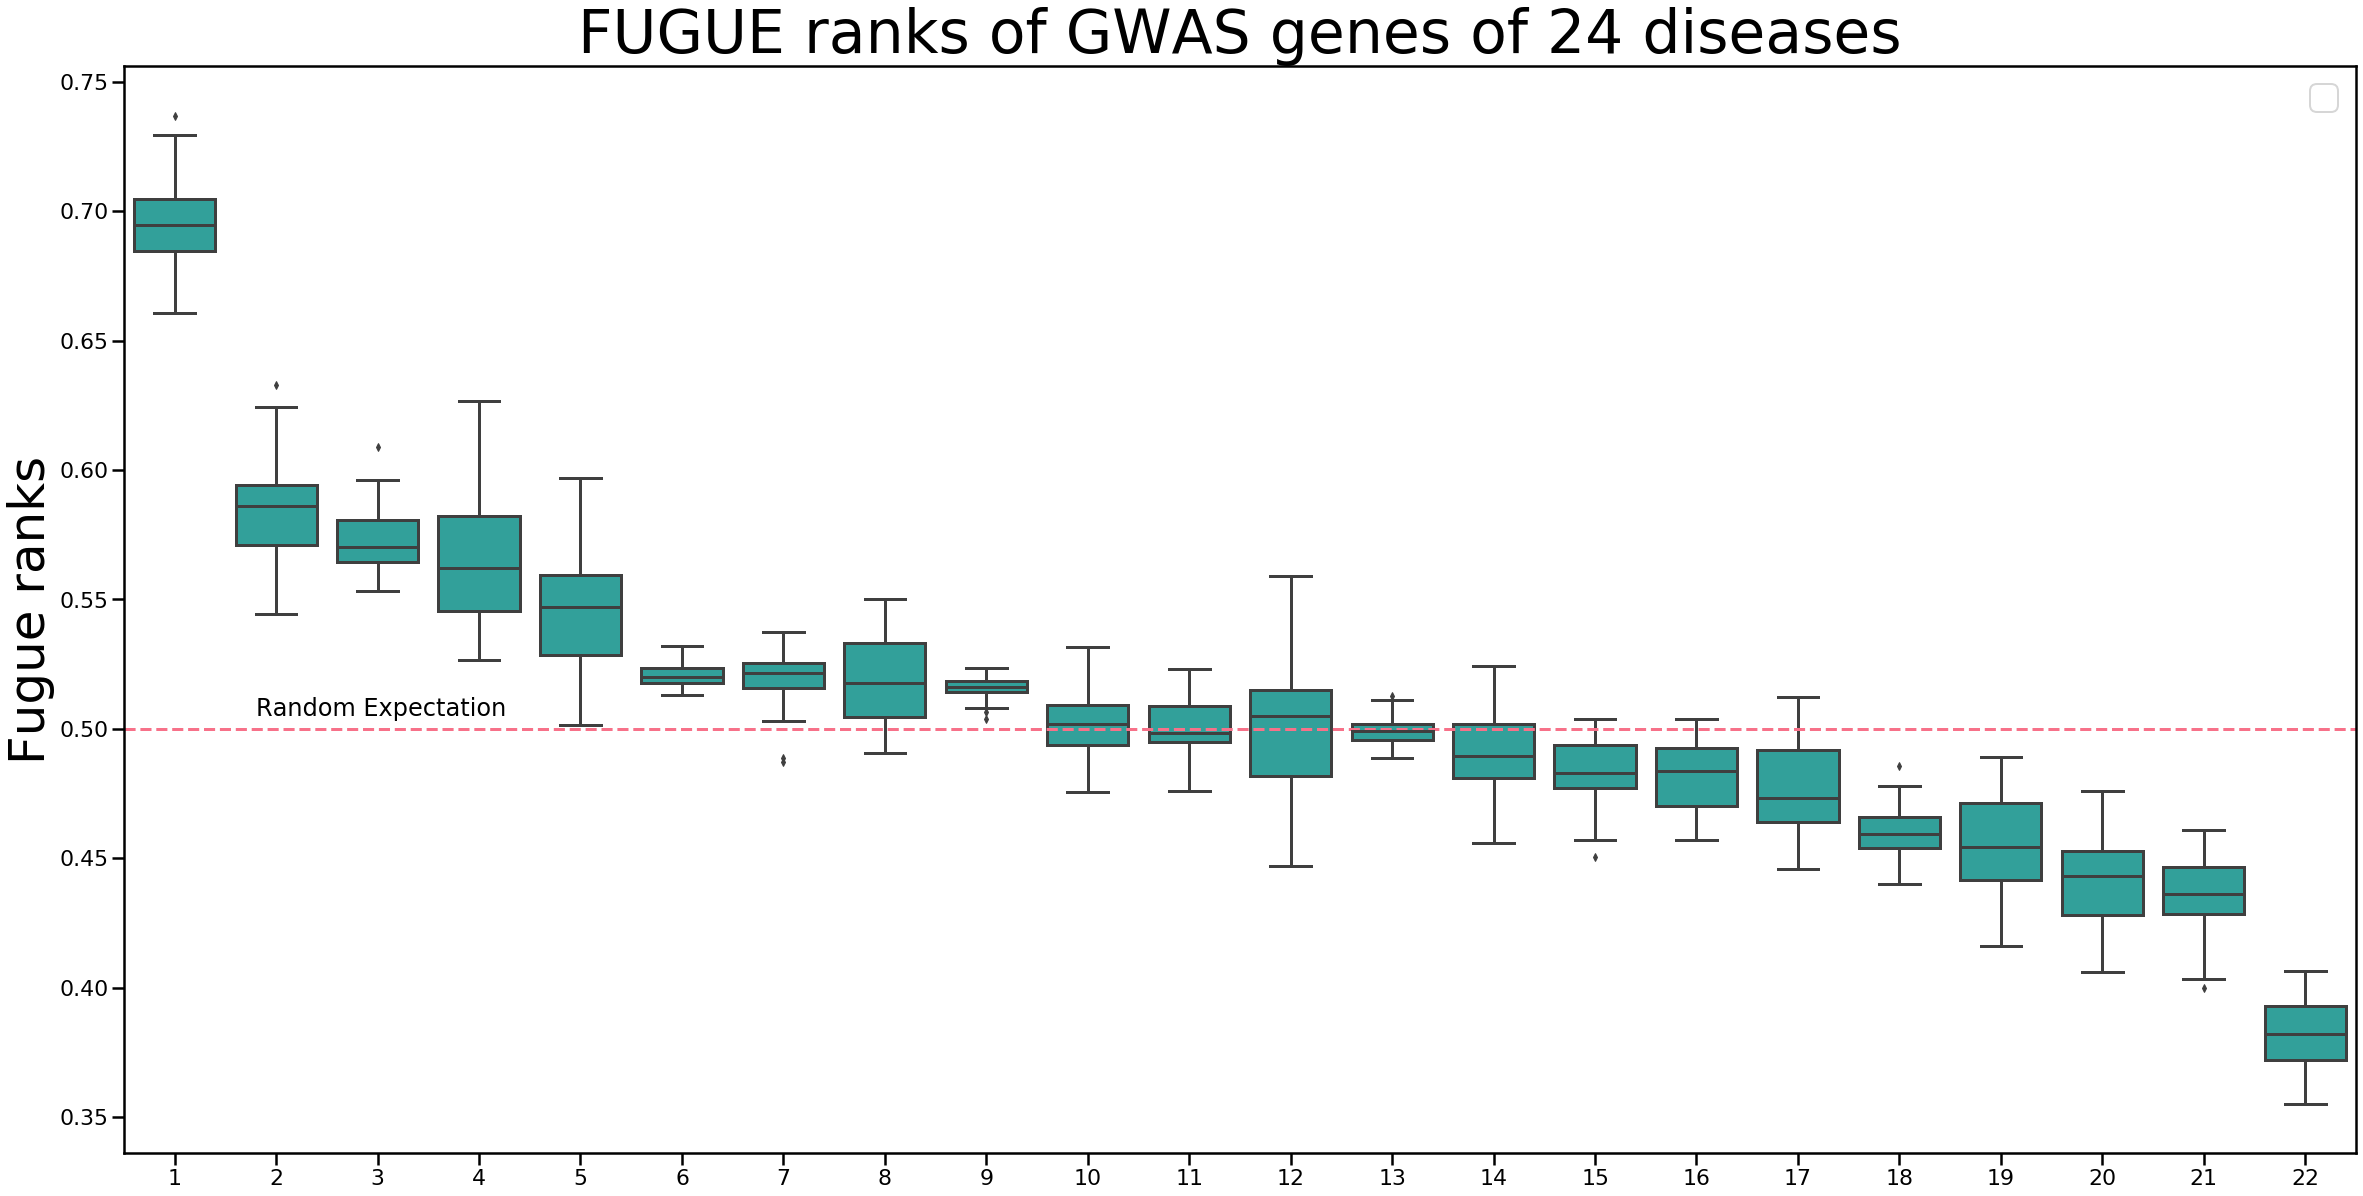

In [19]:

sns.set_context("poster")
fig = plt.figure(figsize=(40,20))

ax = sns.boxplot(x="Disease", y="GWAS_ranks", 
                 data=gwas_val_df_t, color='lightseagreen')
# plt.xticks(rotation=90)
plt.title('FUGUE ranks of GWAS genes of 24 diseases',fontsize=60)

plt.ylabel('Fugue ranks',fontsize = 50)
plt.xlabel('',fontsize = 50)
ax.axhline(0.5, ls='--')
ax.text(0.8,0.505, "Random Expectation")
ax.set_xticklabels(list(range(1,25)))
plt.legend(fontsize=35)
plt.show()

No handles with labels found to put in legend.


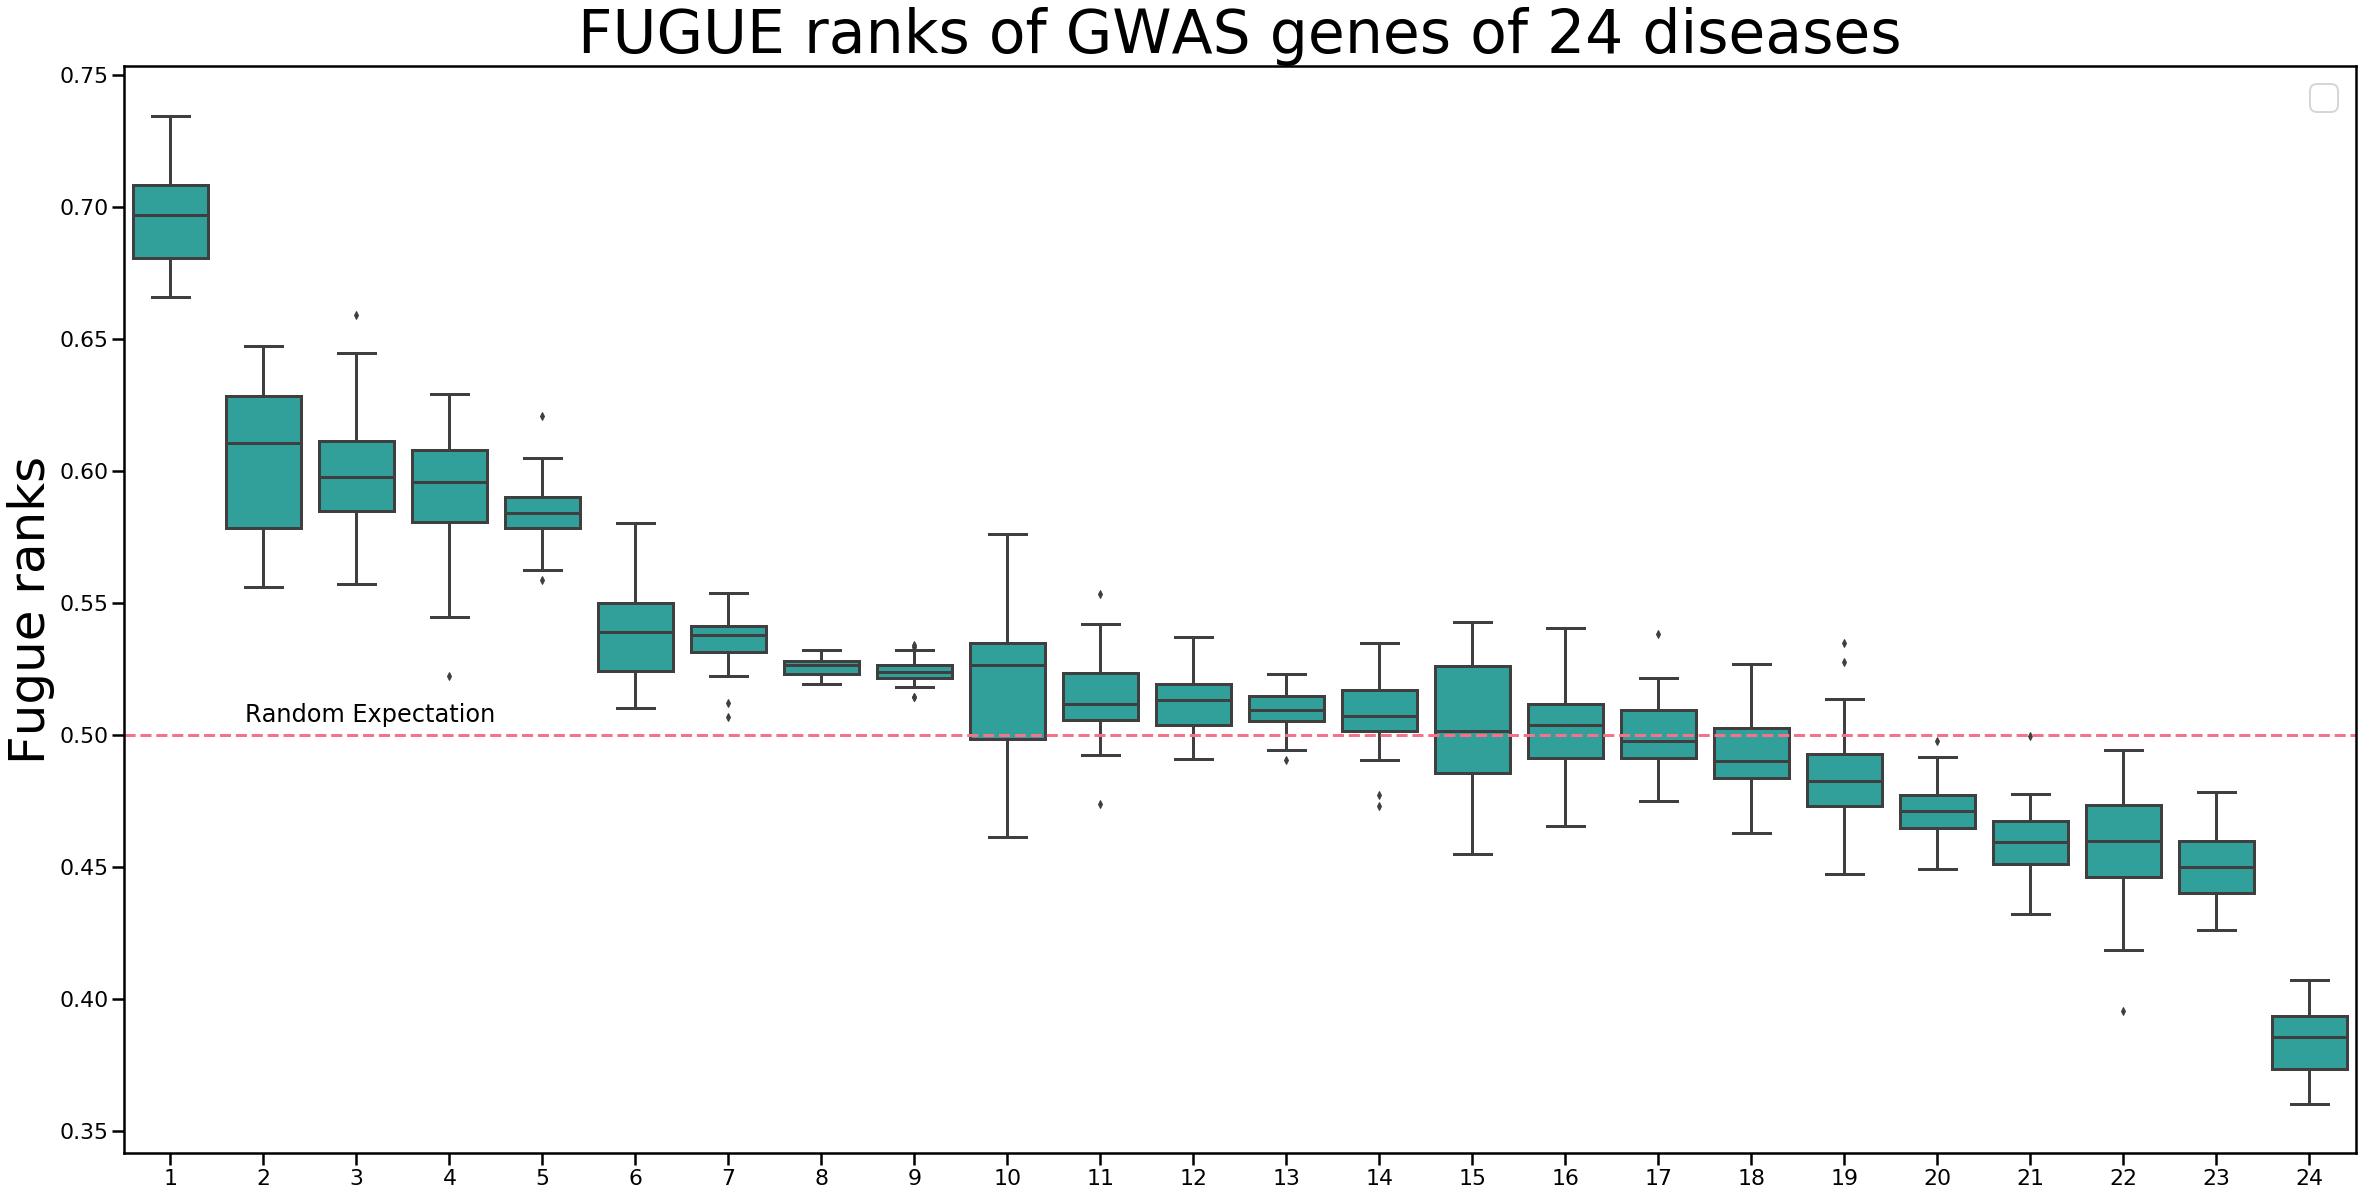

In [44]:

sns.set_context("poster")
fig = plt.figure(figsize=(40,20))

ax = sns.boxplot(x="Disease", y="GWAS_ranks", 
                 data=gwas_val_df_t, color='lightseagreen')
# plt.xticks(rotation=90)
plt.title('FUGUE ranks of GWAS genes of 24 diseases',fontsize=60)

plt.ylabel('Fugue ranks',fontsize = 50)
plt.xlabel('',fontsize = 50)
ax.axhline(0.5, ls='--')
ax.text(0.8,0.505, "Random Expectation")
ax.set_xticklabels(list(range(1,25)))
plt.legend(fontsize=35)
plt.show()

In [21]:
# gwas_val_df = gwas_val_df.sort_values(by=['Mean_Gwas_rank'], ascending=False)
gwas_val_df = gwas_val_df[['Tissue','Disease','GWAS_ranks','Rand_Ranks']]
import itertools
from itertools import chain

tissues = gwas_val_df['Tissue'].tolist()

tissues_rep = list(itertools.chain.from_iterable(itertools.repeat(x, 30) for x in tissues))

diseases = gwas_val_df['Disease'].tolist()
for i in range(len(diseases)):
    diseases[i] = diseases[i][:30]
diseases_rep = list(itertools.chain.from_iterable(itertools.repeat(x, 30) for x in diseases))

gwas_ranks = list(chain.from_iterable(gwas_val_df['GWAS_ranks'].tolist()))
rand_ranks = list(chain.from_iterable(gwas_val_df['Rand_Ranks'].tolist()))

gwas_val_df = pd.DataFrame({'Tissue':tissues_rep,'Disease':diseases_rep,'GWAS_ranks':gwas_ranks,'Rand_Ranks':rand_ranks})
gwas_val_df = pd.melt(gwas_val_df, id_vars=['Tissue','Disease'], value_vars=['GWAS_ranks','Rand_Ranks'])
gwas_val_df.head()

,Tissue,Disease,variable,value
0,Prostate,Prostate-specific antigen leve,GWAS_ranks,0.733195
1,Prostate,Prostate-specific antigen leve,GWAS_ranks,0.716435
2,Prostate,Prostate-specific antigen leve,GWAS_ranks,0.708664
3,Prostate,Prostate-specific antigen leve,GWAS_ranks,0.714377
4,Prostate,Prostate-specific antigen leve,GWAS_ranks,0.696682


In [25]:
dis = gwas_val_df['Disease'].drop_duplicates().tolist()
my_long_labels = []
for d in dis:
    my_long_labels.append(d[:10])

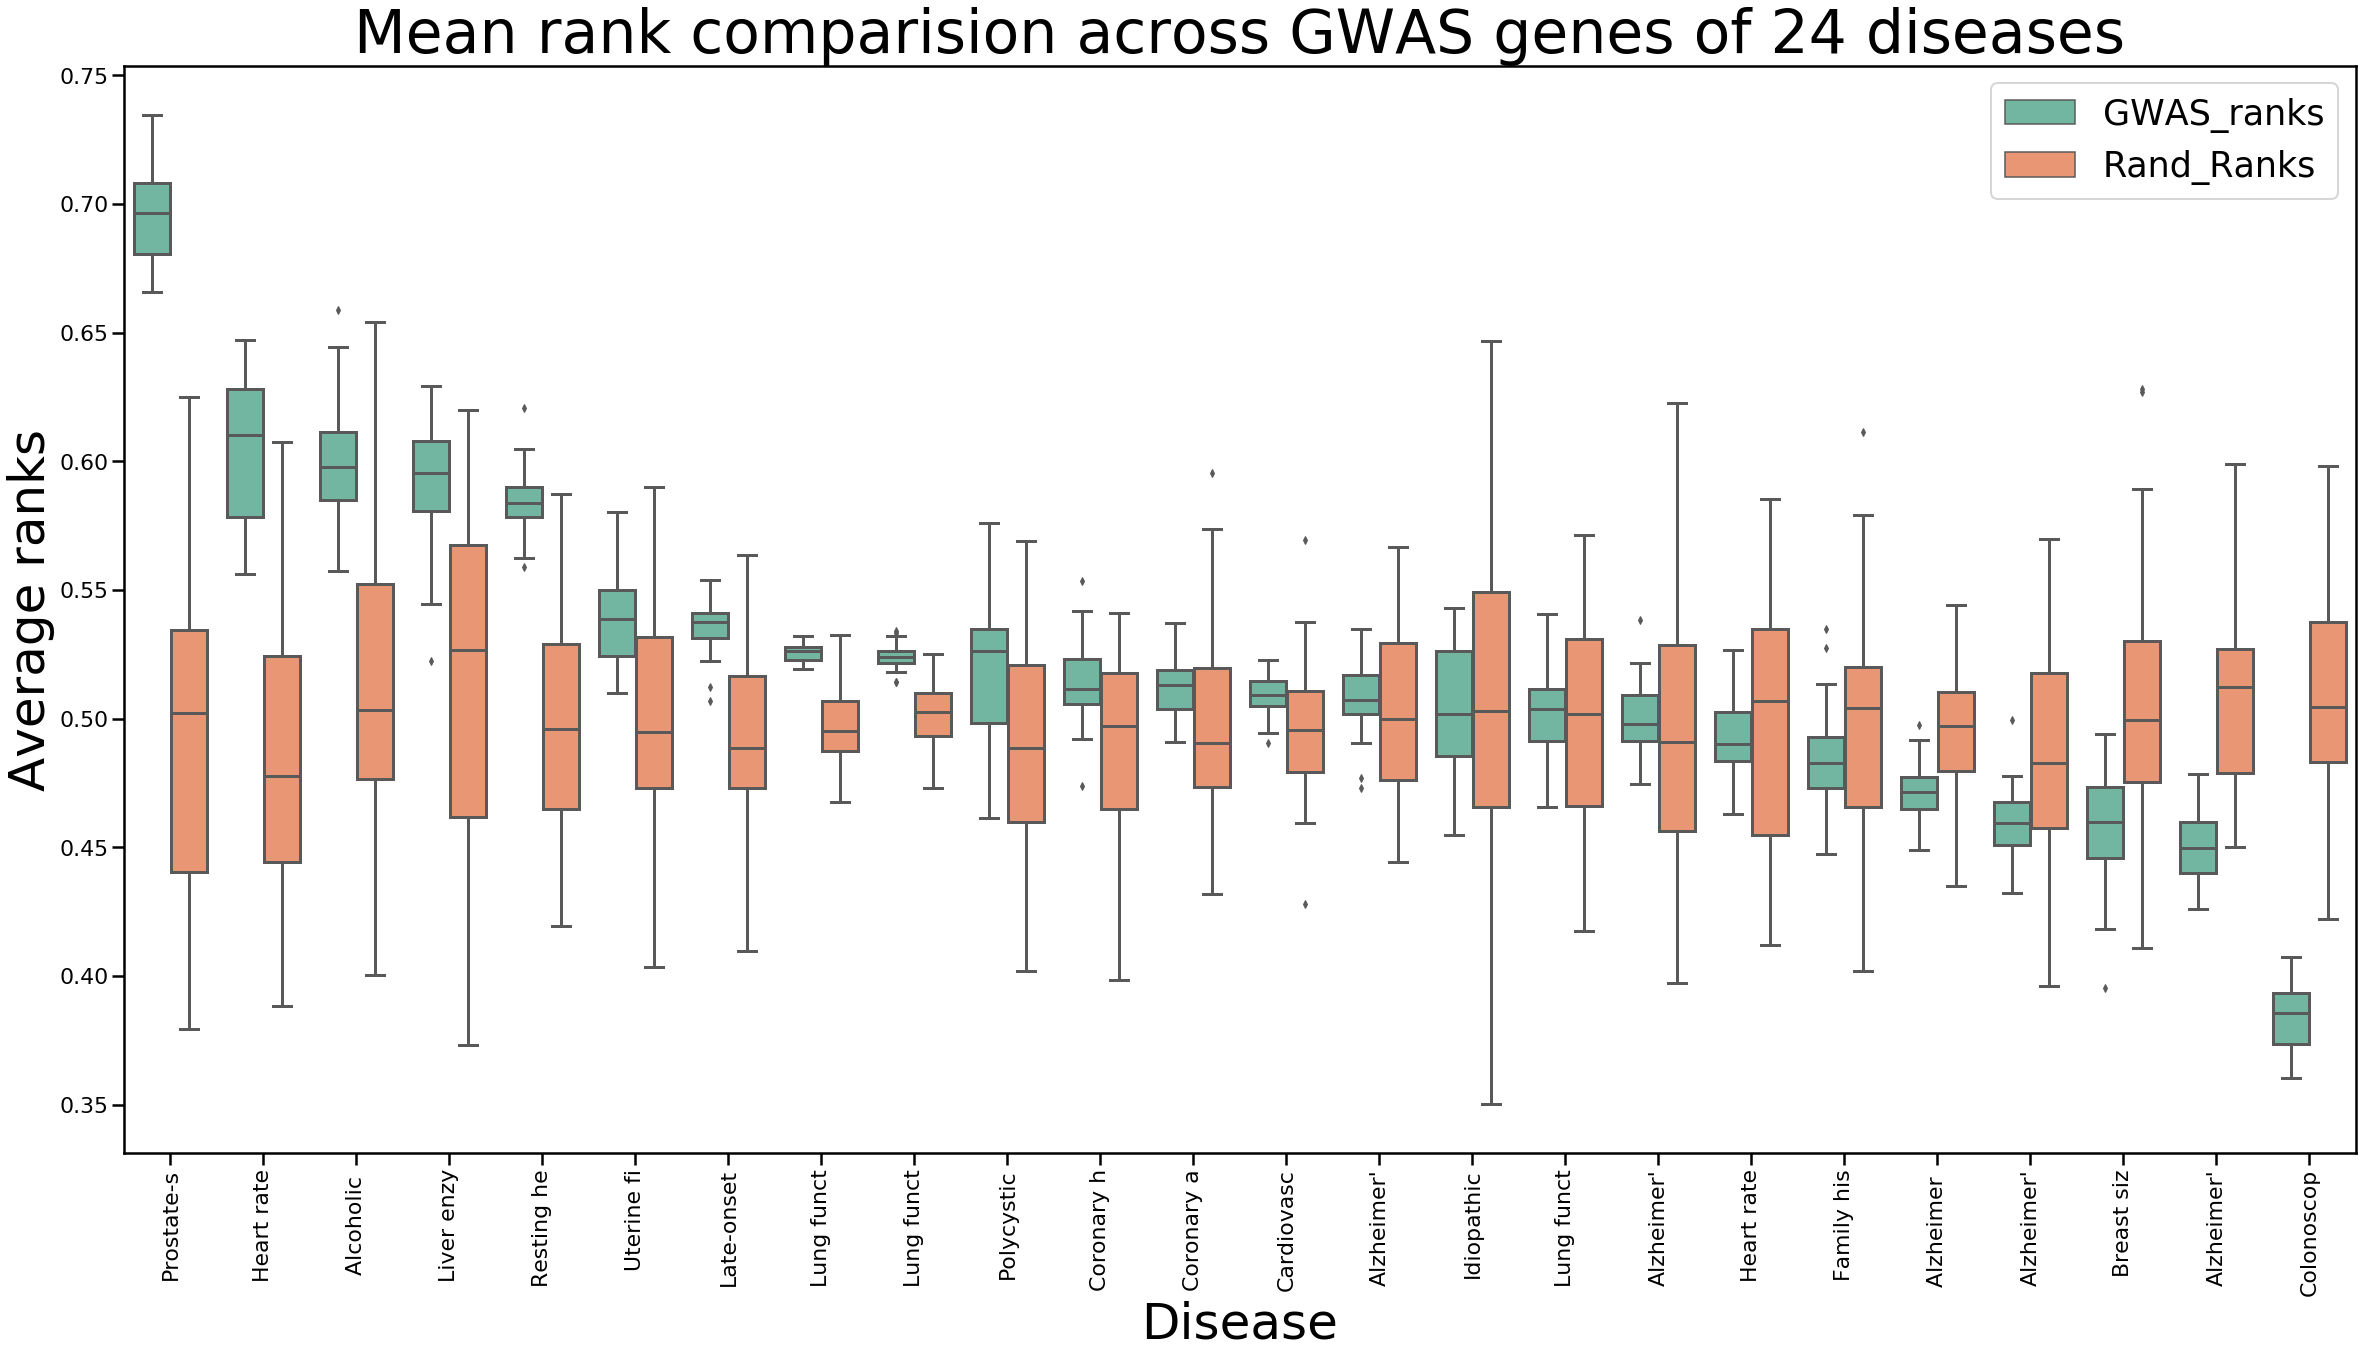

In [33]:

sns.set_context("poster")
fig = plt.figure(figsize=(40,20))

ax = sns.boxplot(x="Disease", y="value", hue="variable",
                 data=gwas_val_df, palette="Set2")
plt.xticks(rotation=90)
plt.title('Mean rank comparision across GWAS genes of 24 diseases',fontsize=60)

plt.ylabel('Fugue ranks',fontsize = 50)
plt.xlabel('',fontsize = 50)
ax.set_xticklabels(my_long_labels)
plt.legend(fontsize=35)
plt.show()

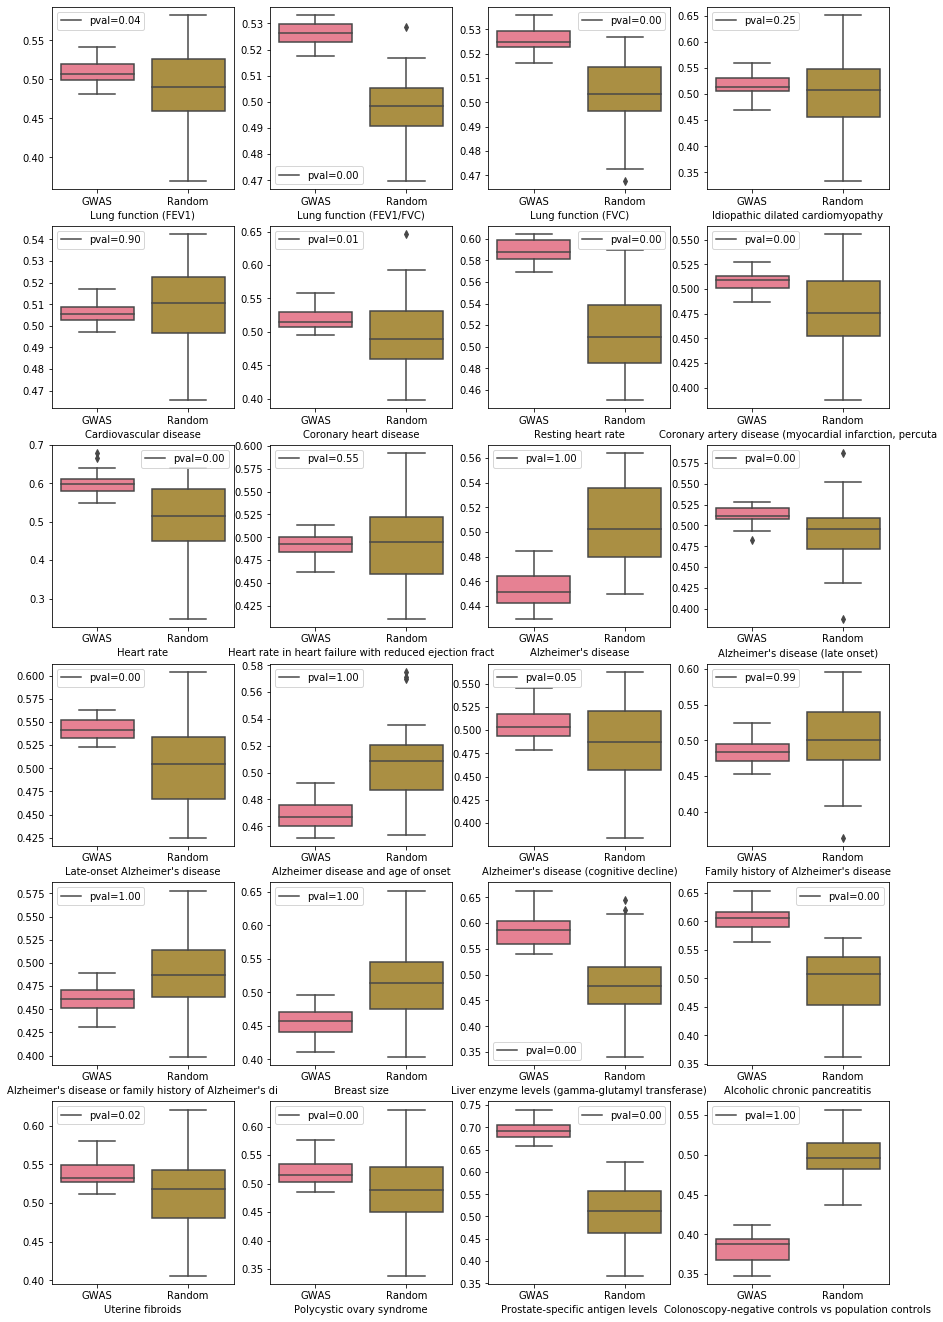

In [14]:

fig = plt.figure(figsize=(15,100))

for i in range(1, 25):
    ax = fig.add_subplot(25, 4, i)
    g = gwas_val_df['GWAS_ranks'][i-1]
    r = gwas_val_df['Rand_Ranks'][i-1]
    ranks  = [g,r]
    names = ['GWAS', 'Random']
    sns.boxplot(data=ranks)
    ax.set(xticklabels=names)
    plt.xlabel(str(gwas_val_df['Disease'][i-1])[:55])
#     plt.ylabel(str(gwas_val_df['Tissue'][i-1]))
    pval = gwas_val_df['pval'][i-1]
    ax.legend(labels = ['pval={0:0.2f}'.format(pval)]) 
#     ax.legend(labels = ['pval={0:0.2f}'.format(pval),'GWAS gene count: '+str(l)]) 

/nfshomes/gowthami/.local/lib/python3.7/site-packages/seaborn/relational.py:784: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
/nfshomes/gowthami/.local/lib/python3.7/site-packages/seaborn/relational.py:795: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)


Text(0.5, 1.0, 'Mean of predicted ranks of GWAS genes vs rest of tissue genes in 24 diseases')

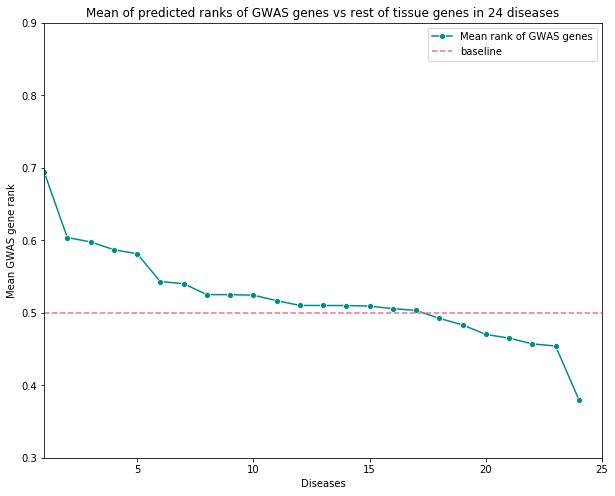

In [8]:
ax = plt.figure(figsize=(10,8))

ax = sns.lineplot(x="disease_numb", y="Mean_Gwas_rank", data=gwas_val_df,marker='o',
                  c = 'darkcyan',label = 'Mean rank of GWAS genes')
ax.set(ylim = (0.3, 0.9))
ax.set(xlim = (1,25))
ax.axhline(y=0.5,label ='baseline',linestyle='dashed')

labels = ["some name", "baseline"]
handles, _ = ax.get_legend_handles_labels()

# Slice list to remove first handle
plt.legend(handles = handles[2:], labels = labels)

plt.xlabel('Diseases')
plt.ylabel('Mean GWAS gene rank')
plt.title('Mean of predicted ranks of GWAS genes vs rest of tissue genes in 24 diseases')

In [9]:
#Use following diseases
disease_list = table_disease[1:30]

tissue_loov_df = pd.read_csv('/fs/cbcb-scratch/gowthami/GTF/GTF_Project_v2/data/tissue_loov_df_50thrsh.csv')
reldf_mean = pd.DataFrame(columns=['Tissue','Probability','Disease'])
for disease in disease_list:
    relg = set(gwas[gwas['DISEASE/TRAIT'].str.contains(disease)]['MAPPED_GENE'].tolist()
              ) & set(gene_loov_df['Gene'].tolist())
    reldf = tissue_loov_df[tissue_loov_df['Gene'].isin(relg)]
#     print(len(relg))
#     print(reldf.shape)
    reldf = reldf.drop(columns = ['Label','Gene'])
    r_mean = reldf.groupby(['Tissue']).median().reset_index()
    r_mean['Disease'] = disease
    reldf_mean = reldf_mean.append(r_mean)
    
# print(reldf_mean.shape)
reldf_mean_2 = reldf_mean[reldf_mean['Tissue'].isin(['Blood','Brain', 'Breast',
                                                    'Kidney', 'Lung', 'Muscle', 'Nerve',
                                                    'Skin','Stomach','Liver', 'Pancreas','Heart','Thyroid',
                                                    'Uterus','Ovary'])]
reldf_mean_2['tissue_rank'] = reldf_mean_2.groupby('Disease')['Probability'].rank(ascending = True)
t_rank = []
for index,row in reldf_mean_2.iterrows():
    disease = row['Disease']
    max_rank = reldf_mean_2.groupby('Disease')['tissue_rank'].max()[disease]
    t_rank.append(row['tissue_rank']/max_rank)
reldf_mean_2['norm_rank'] = t_rank

reldf_mean_mat = reldf_mean_2.pivot("Tissue", "Disease", "norm_rank")

# reldf_mean_mat = reldf_mean.T

plt.rcParams["figure.figsize"] = (15,10)
# ax = sns.heatmap(reldf_mean_mat)
ax = sns.heatmap(reldf_mean_mat,cmap = 'Blues')

FileNotFoundError: [Errno 2] File b'/fs/cbcb-scratch/gowthami/GTF/GTF_Project_v2/data/tissue_loov_df_50thrsh.csv' does not exist: b'/fs/cbcb-scratch/gowthami/GTF/GTF_Project_v2/data/tissue_loov_df_50thrsh.csv'

# Trying out with network

In [24]:
def get_gwas_genes(disease,gwas):
    rel_genes = gwas[gwas['DISEASE/TRAIT']==disease]['MAPPED_GENE'].tolist()
    rel_genes = [x for x in rel_genes if str(x) != 'nan']
    rel_genes = [s.split('-') or s.split(',') for s in rel_genes]
    rel_genes = list(itertools.chain.from_iterable(rel_genes))
    rel_genes = [x.strip(' ') for x in rel_genes]
    return rel_genes
    
def get_gwas_neighb(rel_genes,tissue):
    rel_genes = set(rel_genes)
#     count = 0
    tissue_spec_n = tissue_n[tissue_n['Tissue'] == tissue]
    G = nx.from_pandas_edgelist(tissue_spec_n, 'Gene1', 'Gene2', 'Ratio_val')
    neighb_genes = []
    for gene in rel_genes:
        try:
            neighb_genes+= list(G.neighbors(gene))
            neighb_genes+= [gene]
        except:
#             count+=1
            neighb_genes+= [gene]
#     print(count)       
    return set(neighb_genes)
        
tissue_n = pickle.load( 
    open( "./data_generated/network_generated/all_tissue_network.p", "rb" ) )

tissue_n = tissue_n.drop(columns=['Gene1_ratio','Gene2_ratio'])

tissue_n.head()    
    

,Gene1,Gene2,PPI_val,Ratio_val,Tissue
0,ENSG00000165092,ENSG00000165092,0.76,0.497326,Small Intestine
1,ENSG00000158528,ENSG00000184009,0.65,0.256684,Small Intestine
2,ENSG00000122862,ENSG00000026508,0.63,0.374332,Small Intestine
3,ENSG00000141738,ENSG00000141736,0.90,0.438503,Small Intestine
4,ENSG00000149269,ENSG00000141736,0.73,0.368984,Small Intestine


In [25]:
tissue_keywords = ['Lung','Cardio','Heart','Epilepsy','Alz','Brain','Breast','Liver',
                   'Pancre','Uterin','Gastric','Ovar','Prost','Colon']
gtex_tissues = ['Lung','Heart','Heart','Brain','Brain','Brain','Breast','Liver',
                'Pancreas','Uterus','Stomach','Ovary','Prostate','Colon']

cancerwords = ['noma', 'cancer','Cancer']

# tissue_keywords = ['Cardio']
# gtex_tissues = ['Heart']
table_tissue = []
table_disease = []
table_gg_count = []
table_pval = []
table_mean_gwas_rank = []
for tissue_keyword, gtex_tissue in zip(tissue_keywords,gtex_tissues):
    print(tissue_keyword, gtex_tissue)
    diseases = gwas[gwas['DISEASE/TRAIT'].str.contains(tissue_keyword,
                                                       case=False)]['DISEASE/TRAIT'].drop_duplicates().tolist()
    diseases = [el for el in diseases if not any(ignore in el for ignore in cancerwords)]

    prob_df = gene_loov_df[gene_loov_df['Tissue'] == gtex_tissue]
    prob_df['pct_rank'] = prob_df['Probability'].rank(pct=True)
    
    for disease in diseases:
        gene_set = get_gwas_genes(disease,gwas)
        rel_genes = get_gwas_neighb(gene_set,gtex_tissue)
        gtex_genes = set(prob_df['Description'].tolist())
        gwas_genes = list(set(rel_genes) & gtex_genes)
#         print(len(gene_set),len(rel_genes),len(gtex_genes),len(gwas_genes))

        if len(gwas_genes)>=10:
#             print(gwas_genes)


            gwas_probs = prob_df[prob_df['Description'].isin(gwas_genes)]['pct_rank'].tolist()
            table_mean_gwas_rank.append(np.mean(gwas_probs))
            all_probs = prob_df['pct_rank'].tolist()

            pval =scipy.stats.mannwhitneyu(gwas_probs, all_probs, alternative='greater')[1]
            table_tissue.append(gtex_tissue)
            table_disease.append(disease)
            table_gg_count.append(len(gwas_genes))
            table_pval.append(pval)
#             print(str(disease)+' : '+str(len(gwas_genes)) + ' - Pval: ' + str(pval))
#             _=sns.kdeplot(gwas_probs, shade=True, color = 'darkgoldenrod')
#             _=sns.kdeplot(all_probs, shade=True, color = 'pink')

#     print('-----')

Lung Lung


/cmlscratch/gowthami/Anaconda3/envs/torch_projects/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Cardio Heart
Heart Heart
Epilepsy Brain
Alz Brain
Brain Brain
Breast Breast
Liver Liver
Pancre Pancreas
Uterin Uterus
Gastric Stomach
Ovar Ovary
Prost Prostate
Colon Colon


In [27]:
gwas_val_df = pd.DataFrame({'Tissue': table_tissue,
                           'Disease': table_disease,
                           '#ofgenes': table_gg_count,
                           'pval': table_pval,
                           'Mean_Gwas_rank':table_mean_gwas_rank})

gwas_val_df = gwas_val_df.sort_values(by=['#ofgenes'], ascending=False)
gwas_val_df.to_csv('./data_generated/GWAS_pval_ig_1stdeg_nw.csv',index = False)

print(gwas_val_df.shape)
gwas_val_df.head(30)

(53, 5)


,Tissue,Disease,#ofgenes,pval,Mean_Gwas_rank
1,Lung,Lung function (FEV1/FVC),494,0.029080,0.525038
2,Lung,Lung function (FVC),418,0.040145,0.525068
11,Heart,Cardiovascular disease,224,0.323544,0.508928
31,Brain,Alzheimer disease and age of onset,95,0.853501,0.468792
13,Heart,Resting heart rate,76,0.004510,0.586720
30,Brain,Late-onset Alzheimer's disease,69,0.142898,0.537211
26,Brain,Alzheimer's disease (late onset),64,0.400248,0.509171
52,Colon,Colonoscopy-negative controls vs population co...,62,0.999428,0.380546
15,Heart,Coronary artery disease (myocardial infarction...,56,0.399113,0.509914
34,Brain,Alzheimer's disease or family history of Alzhe...,56,0.841362,0.461383


In [21]:
gwas_val_df['disease_numb'] = gwas_val_df['Mean_Gwas_rank'].rank(ascending = False)

gwas_val_df = gwas_val_df.sort_values(by=['Mean_Gwas_rank'], ascending=True)

gwas_val_df.head(4)

,Tissue,Disease,#ofgenes,pval,Mean_Gwas_rank,disease_numb
10,Heart,Chagas cardiomyopathy in Tripanosoma cruzi ser...,10,0.930270,0.365083,53.0
52,Colon,Colonoscopy-negative controls vs population co...,62,0.999428,0.380546,52.0
36,Brain,Brain structure,12,0.923310,0.381011,51.0
20,Heart,Heart rate response to recovery post exercise ...,10,0.832257,0.412084,50.0


Text(0.5, 1.0, 'Mean of predicted ranks of GWAS genes vs rest of tissue genes in 109 diseases')

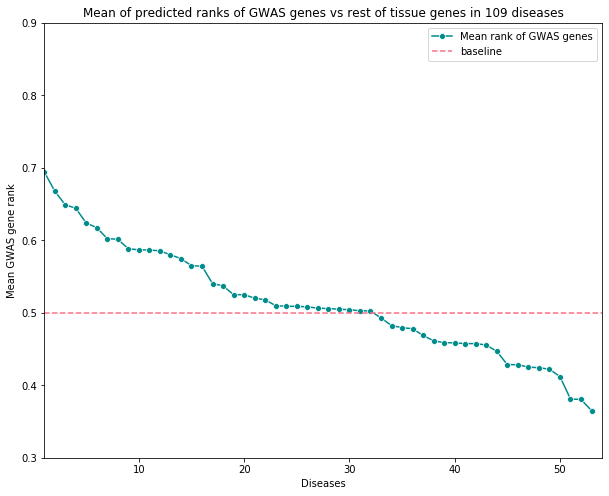

In [23]:
ax = plt.figure(figsize=(10,8))

ax = sns.lineplot(x="disease_numb", y="Mean_Gwas_rank", data=gwas_val_df,marker='o',
                  c = 'darkcyan',label = 'Mean rank of GWAS genes')
ax.set(ylim = (0.3, 0.9))
ax.set(xlim = (1,54))
ax.axhline(y=0.5,label ='baseline',linestyle='dashed')

labels = ["some name", "baseline"]
handles, _ = ax.get_legend_handles_labels()

# Slice list to remove first handle
plt.legend(handles = handles[2:], labels = labels)

plt.xlabel('Diseases')
plt.ylabel('Mean GWAS gene rank')
plt.title('Mean of predicted ranks of GWAS genes vs rest of tissue genes in 109 diseases')